# Assignment 5

In this assignment, you will learn about gradient boosting.

1. Write the code for gradient boosting of trees for solving a binary classification problem from scratch.
2. Download the dataset on Ucilnica "wine-quality.csv".
3. Test different learning rates. What is a good learning rate?
4. Test different numbers of trees that are built during gradient boosting and comment on the results. Does your model overfit? If yes, try to prevent overfitting.
5. Compare the results from your implementation with the "GradientBoostingClassifier" classifier implemented in Scikit-learn.
6. Try modelling your data also with XGBoost, LightGBM and CatBoost models (fit all three models). Compare all the models you built. Be careful to evaluate all three models on the same test dataset.


In [1]:
# Import all dependencies
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    make_scorer,
)


# Ignore warnings
warnings.filterwarnings("ignore")

### Data Retrieval


In [2]:
# Load the wine quality data into a pandas dataframe (use white wine only)
data = pd.read_csv("./data/wine-quality.csv")
data

,Unnamed: 0,X,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,quality,alcohol_level
0,1,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,low,low
1,2,2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,low,low
2,3,3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,low,high
3,4,4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,low,low
4,5,5,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,4894,4894,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,low,high
4894,4895,4895,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,low,low
4895,4896,4896,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,low,low
4896,4897,4897,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,high,high


### Data Preprocessing


In [3]:
# Drop the Unnamed: 0 and X columns
data = data.drop(["Unnamed: 0", "X"], axis=1)

# Rename columns so that they are the same as in Assignment 3
data = data.rename(
    columns={
        "fixed.acidity": "fixed acidity",
        "volatile.acidity": "volatile acidity",
        "citric.acid": "citric acid",
        "residual.sugar": "residual sugar",
        "free.sulfur.dioxide": "free sulfur dioxide",
        "total.sulfur.dioxide": "total sulfur dioxide",
        "density": "density",
        "pH": "pH",
        "sulphates": "sulphates",
        "alcohol_level": "alcohol",
        "quality": "quality",
    }
)

# Swap the order of the columns so that the target variable is the last column
columns = list(data.columns.values)
columns.pop(columns.index("quality"))
data = data[columns + ["quality"]]

# Convert the categorical variable into a numerical variable
data["alcohol"] = data["alcohol"].astype("category").cat.codes
data["quality"] = data["quality"].astype("category").cat.codes

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,0,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,1,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,1,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,0,0


### Data Analyzing


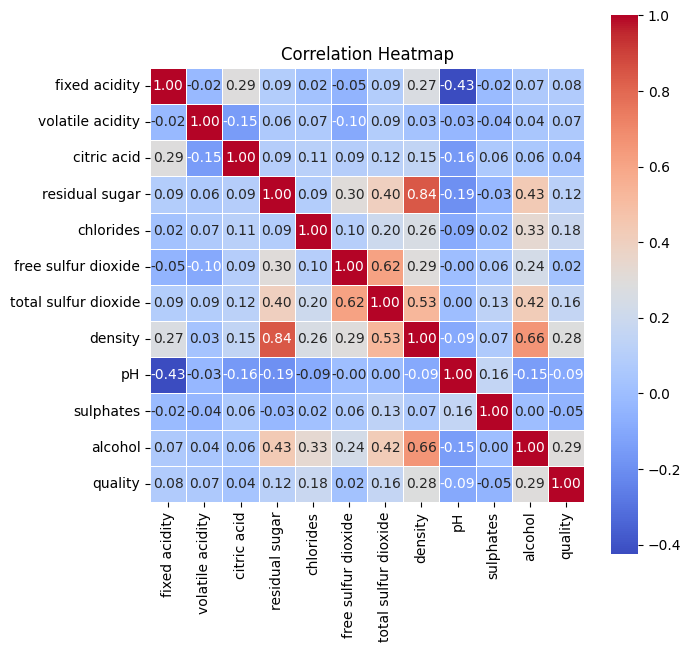

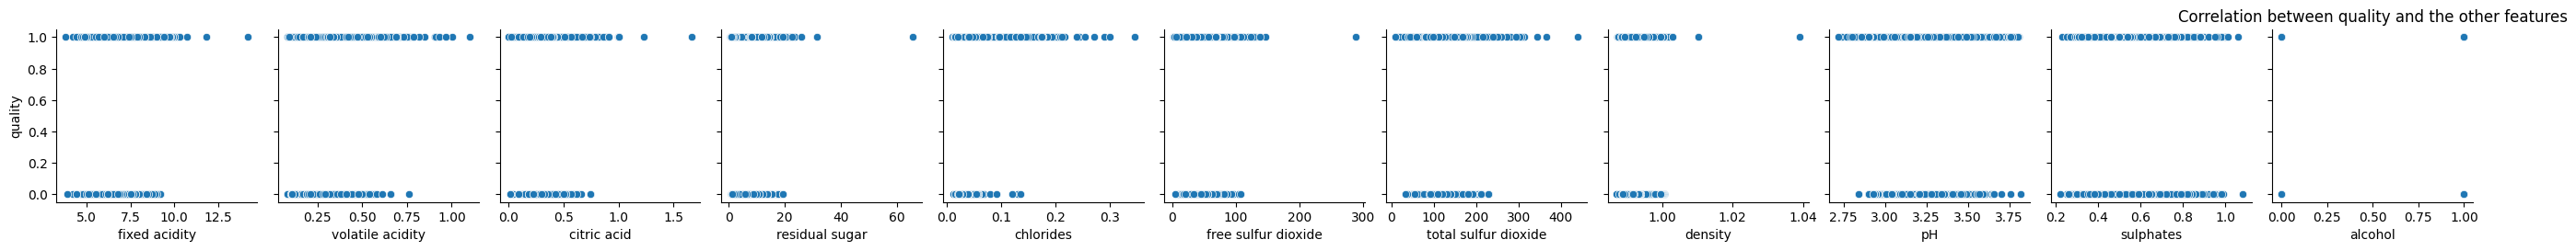

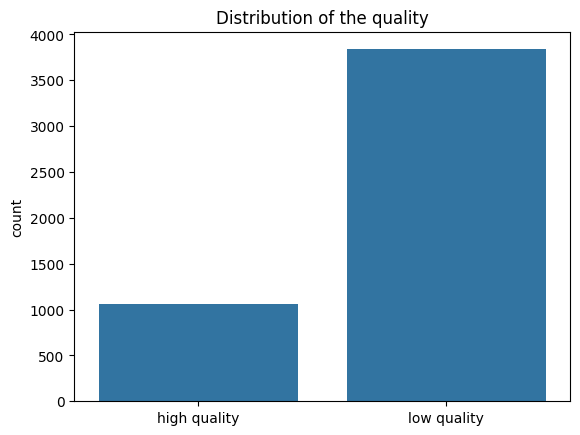

In [4]:
# Exploratory Data Analysis (EDA)
correlation_matrix = data.corr()

_, axis = plt.subplots(1, figsize=(7, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    ax=axis,
)
plt.title("Correlation Heatmap")
plt.show()

# Plot the correlation between the quality and the other features
sns.pairplot(
    data,
    x_vars=[
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ],
    y_vars=["quality"],
)
plt.title("Correlation between quality and the other features")
plt.show()

# Plot the distribution of the quality
sns.countplot(x="quality", data=data)
plt.title("Distribution of the quality")
plt.xticks(ticks=[0, 1], labels=["high quality", "low quality"])
plt.xlabel(None)
plt.show()

### Data Splitting


In [5]:
# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### General Configuration


In [6]:
def findBestProbabilityThreshold(model, X, y):
    # Calculate the probability of each sample belonging to the positive class
    y_probabilities = model.predict_proba(X)[:, 1]

    # Calculate the precision and recall for each probability threshold
    precisions, recalls, thresholds = precision_recall_curve(y, y_probabilities)

    # Calculate the F1 score for each probability threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

    # Find the probability threshold that maximizes the F1 score
    best_threshold_index = np.argmax(f1_scores)

    return thresholds[best_threshold_index]


# Set up k-fold cross-validation (use stratified k-fold because the data is imbalanced)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score),
}

# Calculate the probability threshold because the data is imbalanced
# probability_threshold = findBestProbabilityThreshold(grid_search.best_estimator_)
probability_threshold = 0.68

# Define epsilon to avoid division by zero
epsilon = 1e-10

### My Gradient Boosting Classifier


In [7]:
class MyGradientBoostingClassifier:
    def __init__(
        self, number_of_trees=100, learning_rate=0.1, max_depth=5, min_samples_leaf=1
    ):
        self.number_of_trees = number_of_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        # Calculate the log odds
        log_odds = np.log(sum(y) / sum(1 - y))

        # Initialize the predictions based on the log odds
        predictions_log_odds = np.full_like(y, fill_value=log_odds, dtype=np.float64)

        # Initialize the predictions based on the probability
        # e ^ x / (1 + e ^ x) = 1 / (1 + e ^ -x)
        predictions_probability = 1 / (1 + np.exp(-predictions_log_odds))

        # Create the forest of trees
        for _ in range(self.number_of_trees):
            # Calculate the pseudo-residuals
            residuals = y - predictions_probability

            # Initialize the tree and fit it to the residuals
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, residuals)

            # Transform the predictions from the tree into log odds
            predictions = tree.predict(X) / (
                (predictions_probability * (1 - predictions_probability) + epsilon)
            )

            # Update the predictions for log odds and probability
            predictions_log_odds += self.learning_rate * predictions
            predictions_probability = 1 / (1 + np.exp(-predictions_log_odds))

            # Add the tree to the forest
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions using the forest of trees
        predictions = np.array(
            [self.learning_rate * model.predict(X) for model in self.trees]
        ).sum(axis=0)

        # Calculate the probability
        probability = 1 / (1 + np.exp(-predictions))

        # If the probability is greater than probability_threshold,
        # then the prediction is 1, otherwise it is 0
        return np.where(probability > (1 - probability_threshold), 1, 0)

    def predict_proba(self, X):
        # Make predictions using the forest of trees
        predictions = np.array(
            [self.learning_rate * model.predict(X) for model in self.trees]
        ).sum(axis=0)

        # Calculate the probability
        probability = 1 / (1 + np.exp(-predictions))

        # Return the probability
        return np.array([1 - probability, probability]).T

    def score(self, X, y):
        # Make predictions on the test set
        y_pred = self.predict(X)

        # Calculate the metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_pred)

        return accuracy, precision, recall, f1, roc_auc

    def get_params(self, deep=True):
        return {
            "number_of_trees": self.number_of_trees,
            "learning_rate": self.learning_rate,
            "max_depth": self.max_depth,
            "min_samples_leaf": self.min_samples_leaf,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Finding Hyperparameters


In [8]:
# Find the best parameters for the Gradient Boosting Classifier
parameters = {
    "number_of_trees": [100, 250, 500, 1000, 2500],
    "learning_rate": [0.1, 0.25, 0.5, 0.75, 1],
    "max_depth": [3, 5, 7, 9, 11],
    "min_samples_leaf": [1, 2, 4, 8, 16],
}

# Initialize the grid search
grid_search = GridSearchCV(
    MyGradientBoostingClassifier(),
    parameters,
    cv=k_fold,
    scoring=scoring,
    refit="accuracy",
    return_train_score=True,
    n_jobs=-1,
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Use the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_501641/4138862463.py:40: RuntimeWarning: overflow encountered

Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_leaf': 1, 'number_of_trees': 1000}
Accuracy: 0.81
Precision: 0.81
Recall: 0.99
F1: 0.89
ROC AUC: 0.60


#### Cross Validation


In [9]:
# Perform k-fold cross-validation
best_parameters = grid_search.best_params_
number_of_trees = best_parameters["number_of_trees"]
learning_rate = best_parameters["learning_rate"]
max_depth = best_parameters["max_depth"]
min_samples_leaf = best_parameters["min_samples_leaf"]

# Define a list of the metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

for train_index, test_index in k_fold.split(X_train, y_train):
    # Split the data into training and testing sets
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Initialize and train the Gradient Boosting Classifier
    my_gradient_boosting_classifier = MyGradientBoostingClassifier(
        number_of_trees, learning_rate, max_depth, min_samples_leaf
    )
    my_gradient_boosting_classifier.fit(X_train_fold, y_train_fold)

    # Predict the target values for testing set
    y_pred = my_gradient_boosting_classifier.predict(X_test_fold)

    # Calculate the metrics
    accuracy_scores.append(accuracy_score(y_test_fold, y_pred))
    precision_scores.append(precision_score(y_test_fold, y_pred))
    recall_scores.append(recall_score(y_test_fold, y_pred))
    f1_scores.append(f1_score(y_test_fold, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test_fold, y_pred))

my_results = {
    "accuracy": accuracy_scores,
    "precision": precision_scores,
    "recall": recall_scores,
    "f1": f1_scores,
    "roc_auc": roc_auc_scores,
}

### Gradient Boosting Classifier


In [10]:
sklearn_results = cross_validate(
    GradientBoostingClassifier(),
    X,
    y,
    cv=k_fold,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)

### XGBoost Classifier


In [11]:
xgb_results = cross_validate(
    xgb.XGBClassifier(),
    X,
    y,
    cv=k_fold,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)

### LightGBM Classifier


In [12]:
lgb_results = cross_validate(
    lgb.LGBMClassifier(),
    X,
    y,
    cv=k_fold,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3070, number of negative: 848
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3070, number of negative: 848
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3070, number of negative: 848
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3071, number of negative: 848
[LightGBM] [Info] Number of positive: 3071, number of negative: 848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1262
[LightGBM] [Info] Number of data points in the train set: 3918, 

### CatBoost Classifier


In [13]:
cat_results = cross_validate(
    cat.CatBoostClassifier(silent=True),
    X,
    y,
    cv=k_fold,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)

### Model Evaluation


In [14]:
# Calculate the metrics for my gradient boosting classifier
my_accuracy = np.mean(my_results["accuracy"])
my_precision = np.mean(my_results["precision"])
my_recall = np.mean(my_results["recall"])
my_f1 = np.mean(my_results["f1"])
my_roc_auc = np.mean(my_results["roc_auc"])

# Calculate the metrics for sklearn's gradient boosting classifier
sklearn_accuracy = np.mean(sklearn_results["test_accuracy"])
sklearn_precision = np.mean(sklearn_results["test_precision"])
sklearn_recall = np.mean(sklearn_results["test_recall"])
sklearn_f1 = np.mean(sklearn_results["test_f1"])
sklearn_roc_auc = np.mean(sklearn_results["test_roc_auc"])

# Calculate the metrics for XGBoost
xgb_accuracy = np.mean(xgb_results["test_accuracy"])
xgb_precision = np.mean(xgb_results["test_precision"])
xgb_recall = np.mean(xgb_results["test_recall"])
xgb_f1 = np.mean(xgb_results["test_f1"])
xgb_roc_auc = np.mean(xgb_results["test_roc_auc"])

# Calculate the metrics for LightGBM
lgb_accuracy = np.mean(lgb_results["test_accuracy"])
lgb_precision = np.mean(lgb_results["test_precision"])
lgb_recall = np.mean(lgb_results["test_recall"])
lgb_f1 = np.mean(lgb_results["test_f1"])
lgb_roc_auc = np.mean(lgb_results["test_roc_auc"])

# Calculate the metrics for CatBoost
cat_accuracy = np.mean(cat_results["test_accuracy"])
cat_precision = np.mean(cat_results["test_precision"])
cat_recall = np.mean(cat_results["test_recall"])
cat_f1 = np.mean(cat_results["test_f1"])
cat_roc_auc = np.mean(cat_results["test_roc_auc"])

### Model Comparison


In [15]:
# Compare the evaluation metrics
print(f"[my] Accuracy: {my_accuracy}")
print(f"[my] Precision: {my_precision}")
print(f"[my] Recall: {my_recall}")
print(f"[my] F1: {my_f1}")
print(f"[my] ROC AUC: {my_roc_auc}")
print()
print(f"[sklearn] Accuracy: {sklearn_accuracy}")
print(f"[sklearn] Precision: {sklearn_precision}")
print(f"[sklearn] Recall: {sklearn_recall}")
print(f"[sklearn] F1: {sklearn_f1}")
print(f"[sklearn] ROC AUC: {sklearn_roc_auc}")
print()
print(f"[XGBoost] Accuracy: {xgb_accuracy}")
print(f"[XGBoost] Precision: {xgb_precision}")
print(f"[XGBoost] Recall: {xgb_recall}")
print(f"[XGBoost] F1: {xgb_f1}")
print(f"[XGBoost] ROC AUC: {xgb_roc_auc}")
print()
print(f"[LightGBM] Accuracy: {lgb_accuracy}")
print(f"[LightGBM] Precision: {lgb_precision}")
print(f"[LightGBM] Recall: {lgb_recall}")
print(f"[LightGBM] F1: {lgb_f1}")
print(f"[LightGBM] ROC AUC: {lgb_roc_auc}")
print()
print(f"[CatBoost] Accuracy: {cat_accuracy}")
print(f"[CatBoost] Precision: {cat_precision}")
print(f"[CatBoost] Recall: {cat_recall}")
print(f"[CatBoost] F1: {cat_f1}")
print(f"[CatBoost] ROC AUC: {cat_roc_auc}")

[my] Accuracy: 0.820320197044335
[my] Precision: 0.8193985866174268
[my] Recall: 0.9902755267423015
[my] F1: 0.8967167328108484
[my] ROC AUC: 0.5906106729736325

[sklearn] Accuracy: 0.8325794750995394
[sklearn] Precision: 0.853592201664369
[sklearn] Recall: 0.9491878531073447
[sklearn] F1: 0.8988198634659208
[sklearn] ROC AUC: 0.6797826057989553

[XGBoost] Accuracy: 0.8734149798836798
[XGBoost] Precision: 0.8990645338126233
[XGBoost] Recall: 0.9444976368970013
[XGBoost] F1: 0.9211860961688234
[XGBoost] ROC AUC: 0.780267686373029

[LightGBM] Accuracy: 0.8701459214942361
[LightGBM] Precision: 0.8918719321710966
[LightGBM] Recall: 0.9494489488265971
[LightGBM] F1: 0.919727971380129
[LightGBM] ROC AUC: 0.7662339083755627

[CatBoost] Accuracy: 0.8621827770944945
[CatBoost] Precision: 0.8792129284247995
[CatBoost] Recall: 0.9554419274228596
[CatBoost] F1: 0.9157131669448664
[CatBoost] ROC AUC: 0.7399851146548261


### Diagnostic Plots


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3085, number of negative: 833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787392 -> initscore=1.309273
[LightGBM] [Info] Start training from score 1.309273


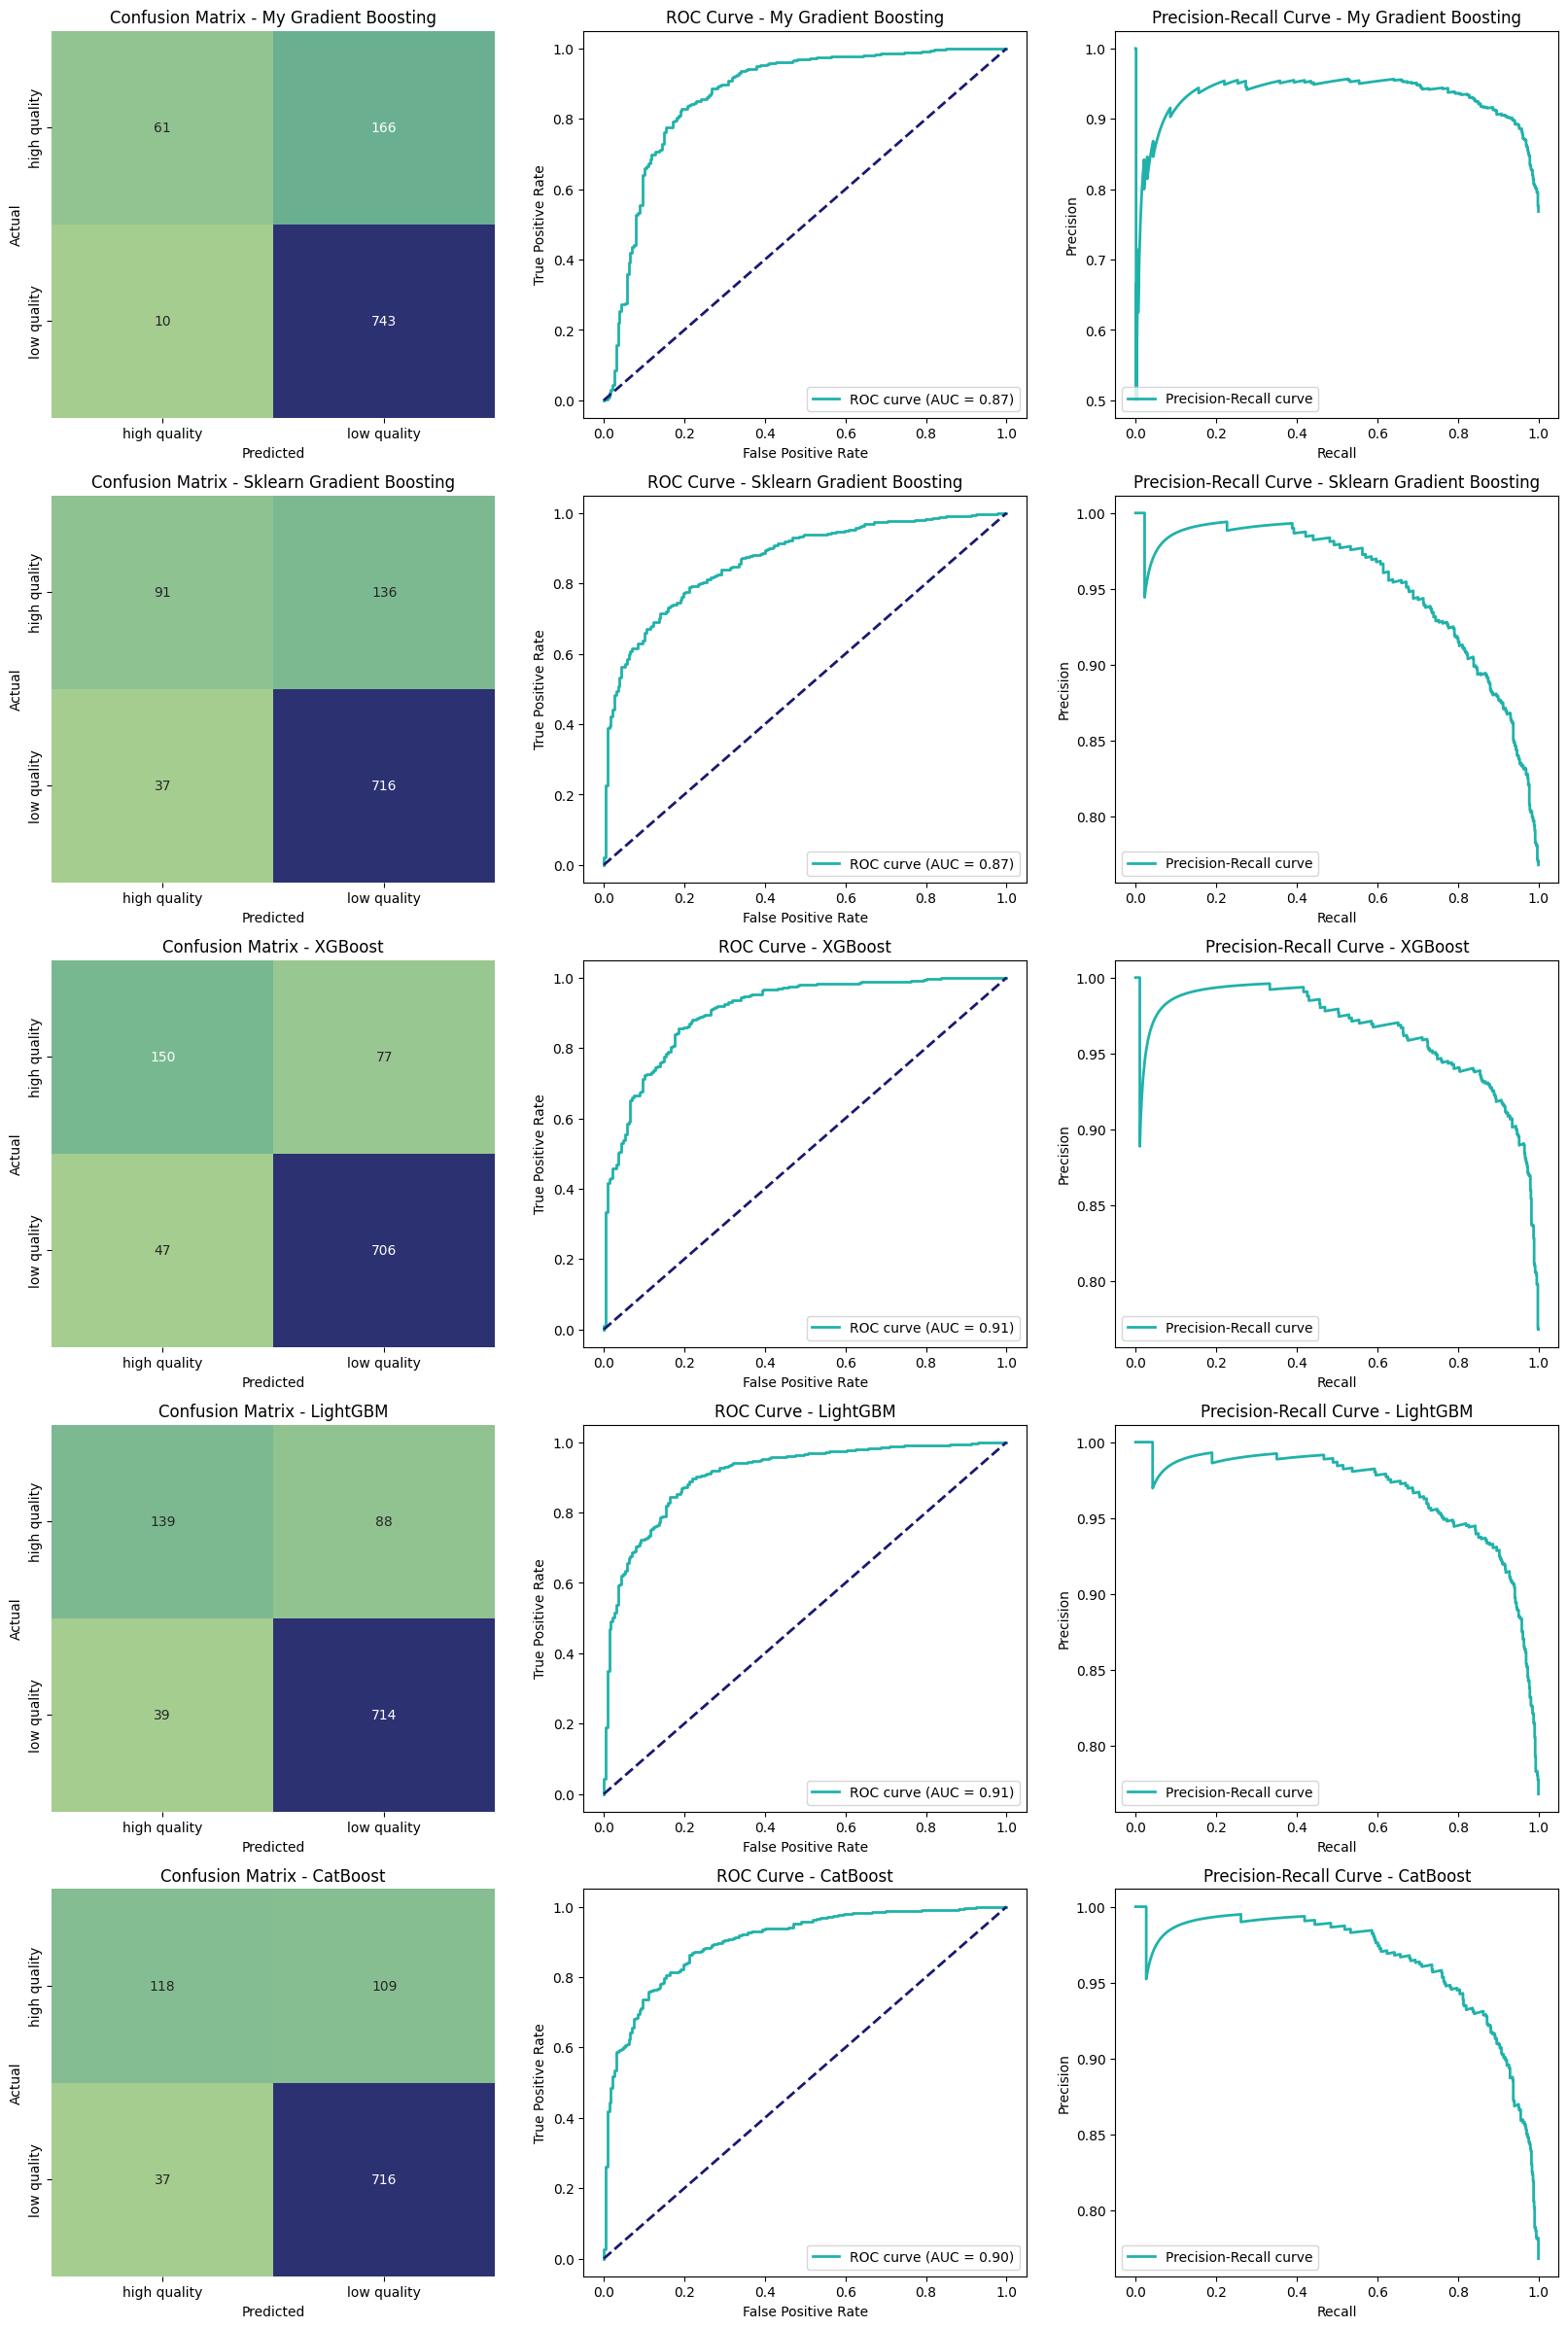

In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name, ax):
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)

    # Plot the heatmap of the confusion matrix
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="crest",
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {model_name}")


# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, model_name, ax):
    # Calculate the false positive rate and true positive rate
    false_positive_rate, true_positive_rage, _ = roc_curve(y_true, y_scores)
    # Calculate the area under the curve
    roc_auc = auc(false_positive_rate, true_positive_rage)

    # Plot the ROC curve and the diagonal line
    ax.plot(
        false_positive_rate,
        true_positive_rage,
        color="lightseagreen",
        lw=2,
        label=f"ROC curve (AUC = {roc_auc:.2f})",
    )
    ax.plot([0, 1], [0, 1], color="midnightblue", lw=2, linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - {model_name}")
    ax.legend(loc="lower right")


# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores, model_name, ax):
    # Calculate the precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plot the Precision-Recall curve
    ax.plot(
        recall, precision, color="lightseagreen", lw=2, label="Precision-Recall curve"
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve - {model_name}")
    ax.legend(loc="lower left")


# Define models
models = [
    ("My Gradient Boosting", MyGradientBoostingClassifier(1000, 0.5, 5, 1)),
    ("Sklearn Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", xgb.XGBClassifier()),
    ("LightGBM", lgb.LGBMClassifier()),
    ("CatBoost", cat.CatBoostClassifier(silent=True)),
]

# Define class names (assuming binary classification)
class_names = ["high quality", "low quality"]

_, axes = plt.subplots(len(models), 3, figsize=(20, 30))

# Loop over models and plot confusion matrix, ROC curve, and Precision-Recall curve
for index, (model_name, model) in enumerate(models):
    # Make predictions
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, class_names, model_name, axes[index][0])

    # Plot ROC curve
    plot_roc_curve(y_test, y_scores, model_name, axes[index][1])

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test, y_scores, model_name, axes[index][2])

plt.show()

### Conclusion

In this assignment we have learned about the gradient boosting algorithm. We have implemented our own gradient boosting classifier and compared it with the gradient boosting classifier from the scikit-learn library. We have also tried to model our data with XGBoost, LightGBM and CatBoost models. We have compared all the models we built and tried to prevent overfitting.

Firstly we noticed that our data is not balanced. We tried to handle this by setting the custom `probability_threshold` parameter in the `predict` method of our gradient boosting classifier. We picked the value so the precision-recall tradeoff was the best. We also used the `StratifiedKFold` cross validation method to prevent overfitting and to maintain the same class distribution in each fold.

Using the `GridSearchCV` method we found the best hyperparameters for our gradient boosting classifier. We found that the best learning rate is 0.5, the best maximum depth is 5, the best minimum number of samples per leaf is 1. We got the best results when we used 1000 trees in our gradient boosting classifier. To sum up, the best hyperparameters for our gradient boosting classifier are: `learning_rate=0.5`, `max_depth=5`, `min_samples_leaf=1`, `number_of_trees=1000`. The number of trees might be a bit high, but we did not notice any overfitting.

As we said we also tried to model our data with scikit-learn's gradient boosting classifier, XGBoost, LightGBM and CatBoost models. We found that the best results were achieved with the XGBoost. The results with the LightGBM and CatBoost models were not as good. Gradient boosting classifier from the scikit-learn library was the worst compared to the other models from external libraries. But even though the results were still better than the results from our gradient boosting classifier, but not by much. To sum up, the best results are shown below:

````json
[my] Accuracy: 0.820320197044335
[my] Precision: 0.8193985866174268
[my] Recall: 0.9902755267423015
[my] F1: 0.8967167328108484
[my] ROC AUC: 0.5906106729736325

[sklearn] Accuracy: 0.8325794750995394
[sklearn] Precision: 0.853592201664369
[sklearn] Recall: 0.9491878531073447
[sklearn] F1: 0.8988198634659208
[sklearn] ROC AUC: 0.6797826057989553

[XGBoost] Accuracy: 0.8734149798836798
[XGBoost] Precision: 0.8990645338126233
[XGBoost] Recall: 0.9444976368970013
[XGBoost] F1: 0.9211860961688234
[XGBoost] ROC AUC: 0.780267686373029

[LightGBM] Accuracy: 0.8701459214942361
[LightGBM] Precision: 0.8918719321710966
[LightGBM] Recall: 0.9494489488265971
[LightGBM] F1: 0.919727971380129
[LightGBM] ROC AUC: 0.7662339083755627

[CatBoost] Accuracy: 0.8621827770944945
[CatBoost] Precision: 0.8792129284247995
[CatBoost] Recall: 0.9554419274228596
[CatBoost] F1: 0.9157131669448664
[CatBoost] ROC AUC: 0.7399851146548261
```

At the end we have also plotted the diagnostic plots. Comparing our model to others we can see that it truly is the worst. We can see that the precision-recall curve is the worst, the ROC curve is the worst and the confusion matrix is the worst. We can also see that the XGBoost model is the best in all three plots. The LightGBM and CatBoost models are also better than our model, but not by much. The scikit-learn's gradient boosting classifier is the second worst in all three plots.
````
